In [ ]:
from gene import Gene

import os
import shutil
import json
from pathlib import Path
from tqdm import trange
import numpy as np
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from colabfold.batch import get_queries, run
from colabfold.download import default_data_dir
from colabfold.utils import setup_logging
from matplotlib import pyplot as plt

In [ ]:

def clear_dir(filepath):
    for root, dirs, files in os.walk(filepath):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

def save_proteins(genes, folder):
    os.mkdir(folder)
    for i, gene in enumerate(genes):
        protein = gene.get_protein()
        record = SeqRecord(protein, id=str(i), description=str(gene))
        filename = f'{folder}/gene{i}.fasta'
        gene.fasta = filename
        SeqIO.write(record, f'{folder}/gene{i}.fasta', 'fasta')
    
def fold(input_dir, result_dir, kwargs):
    setup_logging(Path(result_dir).joinpath("log.txt"))
    kwargs['queries'], kwargs['is_complex'] = get_queries(input_dir)
    kwargs['result_dir'] = result_dir
    results = run(**kwargs)
    return results

def calculate_fitnesses(genes, results):
    for gene, metric in zip(genes, results['metric']):
        mean_plddt, ptm = metric[0]['mean_plddt'], metric[0]['ptm']
        fitness = (mean_plddt / 100) * 0.5 + ptm * 0.5 + len(gene.get_protein()) * 0.01
        gene.fitness = fitness

def log_evolution(generations, logfile):
    with open(logfile, 'w') as f:
        data = [[gene.__dict__ for gene in gen] for gen in generations]
        json.dump(data, f)

def read_evolution(logfile):
    with open(logfile, 'r') as f:
        data = json.load(f)
        generations = [[Gene(**d) for d in gen] for gen in data]
    return generations

def plot_fitnesses(generations):
    fig = plt.figure()
    x = np.arange(len(generations))
    y = [np.mean([gene.fitness for gene in gen]) for gen in generations]
    yerr = [np.std([gene.fitness for gene in gen]) for gen in generations]
    plt.errorbar(x, y, yerr=yerr)
    plt.show()

In [69]:
n_genes = 10
n_bases = 50
n_generations = 10
proteins_path = 'proteins'
folds_path = 'folds'
logfile = 'log.txt'

colabfold_params = {
    'msa_mode': "single_sequence", #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
    'num_models': 1, #@param [1,2,3,4,5] {type:"raw"}
    'num_recycles': 3, #@param [1,3,6,12,24,48] {type:"raw"}
    'stop_at_score': 100, #@param {type:"string"}
    'num_relax': 0, #@param [0, 1, 5] {type:"raw"}
    'use_amber': False,
    'relax_max_iterations': 200, #@param [0,200,2000] {type:"raw"}
    'use_templates': False, #@param {type:"boolean"}
    'keep_existing_results': True, #@param {type:"boolean"}
    'zip_results': False, #@param {type:"boolean"}
    'model_type': "auto",
    'model_order': [1, 2, 3, 4, 5],
    'data_dir': default_data_dir,
    'keep_existing_results': True,
    'rank_by': "auto",
    'pair_mode': "unpaired+paired",
    'user_agent': "colabfold/google-colab-batch",
}

In [72]:
clear_dir(proteins_path)
clear_dir(folds_path)

In [73]:
# first generation
generation = [Gene.generate(n_bases) for _ in range(n_genes)]
# filter empty proteins (begins with stop codon)
generation = [gene for gene in generation if len(gene.get_protein()) > 0]
save_proteins(generation, f'{proteins_path}/gen{0}')
results = fold(f'{proteins_path}/gen{0}', f'{folds_path}/gen{0}', colabfold_params)
calculate_fitnesses(generation, results)
generations = [generation]

# subsequent generations
for i in trange(1, n_generations+1):
    
    mutations = [gene.random_mutation() for gene in generation]
    # remove empty proteins
    mutations = [gene for gene in mutations if len(gene.get_protein()) > 0]

    # fold mutated proteins and calculate fitnesses as a batch
    save_proteins(mutations, f'{proteins_path}/gen{i}')
    results = fold(f'{proteins_path}/gen{i}', f'{folds_path}/gen{i}', colabfold_params)
    calculate_fitnesses(mutations, results)
    generation += mutations

    # stochastic selection
    fitnesses = [gene.fitness for gene in generation]
    generation = np.random.choice(generation, size=n_genes, replace=False, p=np.divide(fitnesses, sum(fitnesses))).tolist()
    generations.append(generation)

log_evolution(generations, logfile)

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-28 17:49:30,438 Running on GPU
2024-12-28 17:49:30,443 Found 2 citations for tools or databases
2024-12-28 17:49:30,443 Query 1/10: gene4 (length 1)
2024-12-28 17:49:33,999 Padding length to 11
2024-12-28 17:49:44,189 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=27 pTM=9.41e-05
2024-12-28 17:49:44,279 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=28.3 pTM=0.00013 tol=0.0001
2024-12-28 17:49:44,366 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.7 pTM=9.8e-05 tol=0.0001
2024-12-28 17:49:44,456 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=47.7 pTM=0.000107 tol=0.0001
2024-12-28 17:49:44,457 alphafold2_ptm_model_1_seed_000 took 10.5s (3 recycles)
2024-12-28 17:49:44,459 reranking models by 'plddt' metric
2024-12-28 17:49:44,459 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=47.7 pTM=0.000107
2024-12-28 17:49:44,784 Query 2/10: gene6 (length 1)
2024-12-28 17:49:45,979 Padding length to 11
2024-12-28 17:49:46,065 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=44.5 pTM=0.

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-28 17:50:09,907 Done


  0%|          | 0/10 [00:00<?, ?it/s]

2024-12-28 17:50:09,913 Running on GPU
2024-12-28 17:50:09,917 Found 2 citations for tools or databases
2024-12-28 17:50:09,919 Query 1/10: gene1 (length 4)


  0%|          | 0/10 [00:03<?, ?it/s]

2024-12-28 17:50:13,417 Padding length to 14


  0%|          | 0/10 [00:12<?, ?it/s]

2024-12-28 17:50:22,707 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.2 pTM=0.09
2024-12-28 17:50:22,813 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=24 pTM=0.00192 tol=9.15


  0%|          | 0/10 [00:13<?, ?it/s]

2024-12-28 17:50:22,918 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=27.6 pTM=0.00225 tol=9.82
2024-12-28 17:50:23,022 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=31.1 pTM=0.00113 tol=19.5
2024-12-28 17:50:23,025 alphafold2_ptm_model_1_seed_000 took 9.6s (3 recycles)
2024-12-28 17:50:23,029 reranking models by 'plddt' metric
2024-12-28 17:50:23,030 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=31.1 pTM=0.00113


  0%|          | 0/10 [00:13<?, ?it/s]

2024-12-28 17:50:23,330 Query 2/10: gene3 (length 4)


  0%|          | 0/10 [00:14<?, ?it/s]

2024-12-28 17:50:24,453 Padding length to 14
2024-12-28 17:50:24,558 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=74.2 pTM=0.0925


  0%|          | 0/10 [00:14<?, ?it/s]

2024-12-28 17:50:24,660 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=31.9 pTM=0.00209 tol=2.07
2024-12-28 17:50:24,762 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=28.6 pTM=0.000521 tol=29.6


  0%|          | 0/10 [00:14<?, ?it/s]

2024-12-28 17:50:24,865 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=34 pTM=0.000656 tol=11.7
2024-12-28 17:50:24,868 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:50:24,872 reranking models by 'plddt' metric
2024-12-28 17:50:24,874 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=34 pTM=0.000656


  0%|          | 0/10 [00:15<?, ?it/s]

2024-12-28 17:50:25,168 Query 3/10: gene4 (length 5)


  0%|          | 0/10 [00:16<?, ?it/s]

2024-12-28 17:50:26,280 Padding length to 14
2024-12-28 17:50:26,385 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.4 pTM=0.0827


  0%|          | 0/10 [00:16<?, ?it/s]

2024-12-28 17:50:26,489 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.1 pTM=0.0822 tol=2.63
2024-12-28 17:50:26,593 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=52.5 pTM=0.0751 tol=1.69


  0%|          | 0/10 [00:16<?, ?it/s]

2024-12-28 17:50:26,697 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=46.7 pTM=0.0673 tol=1.21
2024-12-28 17:50:26,698 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:50:26,702 reranking models by 'plddt' metric
2024-12-28 17:50:26,703 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=46.7 pTM=0.0673


  0%|          | 0/10 [00:17<?, ?it/s]

2024-12-28 17:50:27,014 Query 4/10: gene8 (length 7)


  0%|          | 0/10 [00:18<?, ?it/s]

2024-12-28 17:50:28,156 Padding length to 14
2024-12-28 17:50:28,261 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=80.4 pTM=0.063


  0%|          | 0/10 [00:18<?, ?it/s]

2024-12-28 17:50:28,366 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=83.4 pTM=0.0624 tol=0.0933
2024-12-28 17:50:28,469 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=83.6 pTM=0.0627 tol=0.0428


  0%|          | 0/10 [00:18<?, ?it/s]

2024-12-28 17:50:28,573 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.2 pTM=0.0624 tol=0.185
2024-12-28 17:50:28,576 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:50:28,580 reranking models by 'plddt' metric
2024-12-28 17:50:28,582 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.2 pTM=0.0624


  0%|          | 0/10 [00:18<?, ?it/s]

2024-12-28 17:50:28,874 Query 5/10: gene5 (length 10)


  0%|          | 0/10 [00:20<?, ?it/s]

2024-12-28 17:50:29,992 Padding length to 14
2024-12-28 17:50:30,097 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68 pTM=0.0446


  0%|          | 0/10 [00:20<?, ?it/s]

2024-12-28 17:50:30,203 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76 pTM=0.0454 tol=0.475
2024-12-28 17:50:30,307 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.4 pTM=0.0457 tol=0.154


  0%|          | 0/10 [00:20<?, ?it/s]

2024-12-28 17:50:30,412 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=77.6 pTM=0.0458 tol=0.122
2024-12-28 17:50:30,415 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:50:30,420 reranking models by 'plddt' metric
2024-12-28 17:50:30,422 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=77.6 pTM=0.0458


  0%|          | 0/10 [00:20<?, ?it/s]

2024-12-28 17:50:30,729 Query 6/10: gene6 (length 10)


  0%|          | 0/10 [00:22<?, ?it/s]

2024-12-28 17:50:31,833 Padding length to 14
2024-12-28 17:50:31,938 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73 pTM=0.0428


  0%|          | 0/10 [00:22<?, ?it/s]

2024-12-28 17:50:32,043 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.6 pTM=0.0427 tol=0.28
2024-12-28 17:50:32,146 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=74.5 pTM=0.043 tol=0.238


  0%|          | 0/10 [00:22<?, ?it/s]

2024-12-28 17:50:32,252 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=73.2 pTM=0.0428 tol=0.39
2024-12-28 17:50:32,255 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:50:32,261 reranking models by 'plddt' metric
2024-12-28 17:50:32,265 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=73.2 pTM=0.0428


  0%|          | 0/10 [00:22<?, ?it/s]

2024-12-28 17:50:32,590 Query 7/10: gene2 (length 16)


  0%|          | 0/10 [00:23<?, ?it/s]

2024-12-28 17:50:33,713 Padding length to 17


  0%|          | 0/10 [00:35<?, ?it/s]

2024-12-28 17:50:45,200 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.3 pTM=0.0265
2024-12-28 17:50:45,319 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=72.1 pTM=0.0276 tol=0.297


  0%|          | 0/10 [00:35<?, ?it/s]

2024-12-28 17:50:45,439 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.1 pTM=0.0279 tol=0.265
2024-12-28 17:50:45,558 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=73.6 pTM=0.0279 tol=0.312
2024-12-28 17:50:45,560 alphafold2_ptm_model_1_seed_000 took 11.8s (3 recycles)
2024-12-28 17:50:45,564 reranking models by 'plddt' metric
2024-12-28 17:50:45,566 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=73.6 pTM=0.0279


  0%|          | 0/10 [00:35<?, ?it/s]

2024-12-28 17:50:45,865 Query 8/10: gene0 (length 17)


  0%|          | 0/10 [00:37<?, ?it/s]

2024-12-28 17:50:47,140 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=72.8 pTM=0.0357
2024-12-28 17:50:47,259 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.0381 tol=0.184


  0%|          | 0/10 [00:37<?, ?it/s]

2024-12-28 17:50:47,378 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78.1 pTM=0.0388 tol=0.0957
2024-12-28 17:50:47,499 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=78.1 pTM=0.0389 tol=0.0431
2024-12-28 17:50:47,501 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:50:47,507 reranking models by 'plddt' metric
2024-12-28 17:50:47,509 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=78.1 pTM=0.0389


  0%|          | 0/10 [00:37<?, ?it/s]

2024-12-28 17:50:47,822 Query 9/10: gene7 (length 17)


  0%|          | 0/10 [00:39<?, ?it/s]

2024-12-28 17:50:49,060 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=57.1 pTM=0.0233
2024-12-28 17:50:49,180 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.5 pTM=0.0236 tol=1.57


  0%|          | 0/10 [00:39<?, ?it/s]

2024-12-28 17:50:49,300 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=59 pTM=0.0237 tol=1.52
2024-12-28 17:50:49,420 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=59.2 pTM=0.0236 tol=0.462
2024-12-28 17:50:49,423 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:50:49,429 reranking models by 'plddt' metric
2024-12-28 17:50:49,431 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=59.2 pTM=0.0236


  0%|          | 0/10 [00:39<?, ?it/s]

2024-12-28 17:50:49,771 Query 10/10: gene9 (length 17)


  0%|          | 0/10 [00:41<?, ?it/s]

2024-12-28 17:50:51,004 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=69.4 pTM=0.0306
2024-12-28 17:50:51,124 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=70.8 pTM=0.0315 tol=2.2


  0%|          | 0/10 [00:41<?, ?it/s]

2024-12-28 17:50:51,242 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.7 pTM=0.0316 tol=1.87
2024-12-28 17:50:51,362 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.5 pTM=0.0316 tol=0.364
2024-12-28 17:50:51,365 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:50:51,371 reranking models by 'plddt' metric
2024-12-28 17:50:51,373 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.5 pTM=0.0316


  0%|          | 0/10 [00:41<?, ?it/s]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 10%|█         | 1/10 [00:41<06:15, 41.77s/it]

2024-12-28 17:50:51,678 Done
2024-12-28 17:50:51,685 Running on GPU
2024-12-28 17:50:51,689 Found 2 citations for tools or databases
2024-12-28 17:50:51,692 Query 1/10: gene7 (length 3)


 10%|█         | 1/10 [00:45<06:15, 41.77s/it]

2024-12-28 17:50:55,019 Padding length to 13


 10%|█         | 1/10 [00:54<06:15, 41.77s/it]

2024-12-28 17:51:03,903 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=61.6 pTM=0.118
2024-12-28 17:51:04,022 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=26 pTM=0.000547 tol=15.1


 10%|█         | 1/10 [00:54<06:15, 41.77s/it]

2024-12-28 17:51:04,125 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.2 pTM=0.000851 tol=23.2
2024-12-28 17:51:04,227 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=29.7 pTM=0.000586 tol=24.3
2024-12-28 17:51:04,230 alphafold2_ptm_model_1_seed_000 took 9.2s (3 recycles)
2024-12-28 17:51:04,234 reranking models by 'plddt' metric
2024-12-28 17:51:04,236 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=29.7 pTM=0.000586


 10%|█         | 1/10 [00:54<06:15, 41.77s/it]

2024-12-28 17:51:04,550 Query 2/10: gene9 (length 4)


2024-12-28 17:51:05,683 Padding length to 13
2024-12-28 17:51:05,783 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=65.2 pTM=0.092
2024-12-28 17:51:05,883 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=47.1 pTM=0.0108 tol=1.63


 10%|█         | 1/10 [00:56<06:15, 41.77s/it]

2024-12-28 17:51:05,984 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=33.1 pTM=0.00262 tol=17.4
2024-12-28 17:51:06,084 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=24.3 pTM=0.000971 tol=16
2024-12-28 17:51:06,087 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:06,091 reranking models by 'plddt' metric
2024-12-28 17:51:06,093 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=24.3 pTM=0.000971


 10%|█         | 1/10 [00:56<06:15, 41.77s/it]

2024-12-28 17:51:06,394 Query 3/10: gene1 (length 7)


 10%|█         | 1/10 [00:57<06:15, 41.77s/it]

2024-12-28 17:51:07,512 Padding length to 13
2024-12-28 17:51:07,614 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.6 pTM=0.061


 10%|█         | 1/10 [00:57<06:15, 41.77s/it]

2024-12-28 17:51:07,714 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=72.9 pTM=0.0608 tol=0.303
2024-12-28 17:51:07,816 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=65.4 pTM=0.0611 tol=0.942


 10%|█         | 1/10 [00:58<06:15, 41.77s/it]

2024-12-28 17:51:07,916 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.9 pTM=0.0614 tol=0.277
2024-12-28 17:51:07,919 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:07,925 reranking models by 'plddt' metric
2024-12-28 17:51:07,927 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.9 pTM=0.0614


 10%|█         | 1/10 [00:58<06:15, 41.77s/it]

2024-12-28 17:51:08,236 Query 4/10: gene3 (length 7)


 10%|█         | 1/10 [00:59<06:15, 41.77s/it]

2024-12-28 17:51:09,340 Padding length to 13
2024-12-28 17:51:09,441 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=80.4 pTM=0.063
2024-12-28 17:51:09,540 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=83.4 pTM=0.0624 tol=0.0933


 10%|█         | 1/10 [00:59<06:15, 41.77s/it]

2024-12-28 17:51:09,640 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=83.6 pTM=0.0627 tol=0.0428
2024-12-28 17:51:09,740 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.2 pTM=0.0624 tol=0.185
2024-12-28 17:51:09,743 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:09,747 reranking models by 'plddt' metric
2024-12-28 17:51:09,750 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.2 pTM=0.0624


 10%|█         | 1/10 [01:00<06:15, 41.77s/it]

2024-12-28 17:51:10,047 Query 5/10: gene6 (length 7)


2024-12-28 17:51:11,207 Padding length to 13
2024-12-28 17:51:11,308 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.6 pTM=0.0585


2024-12-28 17:51:11,409 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=71.3 pTM=0.0592 tol=0.465
2024-12-28 17:51:11,507 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.5 pTM=0.0593 tol=0.205
2024-12-28 17:51:11,608 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=68.1 pTM=0.0593 tol=0.252


 10%|█         | 1/10 [01:01<06:15, 41.77s/it]

2024-12-28 17:51:11,610 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:11,613 reranking models by 'plddt' metric
2024-12-28 17:51:11,615 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=68.1 pTM=0.0593


 10%|█         | 1/10 [01:02<06:15, 41.77s/it]

2024-12-28 17:51:11,925 Query 6/10: gene8 (length 7)


 10%|█         | 1/10 [01:03<06:15, 41.77s/it]

2024-12-28 17:51:13,049 Padding length to 13
2024-12-28 17:51:13,149 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=80.4 pTM=0.063
2024-12-28 17:51:13,249 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=83.4 pTM=0.0624 tol=0.0933


 10%|█         | 1/10 [01:03<06:15, 41.77s/it]

2024-12-28 17:51:13,351 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=83.6 pTM=0.0627 tol=0.0428
2024-12-28 17:51:13,453 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.2 pTM=0.0624 tol=0.185
2024-12-28 17:51:13,456 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:13,462 reranking models by 'plddt' metric
2024-12-28 17:51:13,465 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.2 pTM=0.0624


 10%|█         | 1/10 [01:03<06:15, 41.77s/it]

2024-12-28 17:51:13,771 Query 7/10: gene5 (length 15)


 10%|█         | 1/10 [01:04<06:15, 41.77s/it]

2024-12-28 17:51:14,875 Padding length to 17


 10%|█         | 1/10 [01:12<06:15, 41.77s/it]

2024-12-28 17:51:22,339 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=69.3 pTM=0.033
2024-12-28 17:51:22,478 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=75.6 pTM=0.0364 tol=0.444


 10%|█         | 1/10 [01:12<06:15, 41.77s/it]

2024-12-28 17:51:22,600 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.5 pTM=0.0373 tol=0.105
2024-12-28 17:51:22,719 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.7 pTM=0.0374 tol=0.03
2024-12-28 17:51:22,722 alphafold2_ptm_model_1_seed_000 took 7.8s (3 recycles)
2024-12-28 17:51:22,728 reranking models by 'plddt' metric
2024-12-28 17:51:22,730 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.7 pTM=0.0374


 10%|█         | 1/10 [01:13<06:15, 41.77s/it]

2024-12-28 17:51:23,039 Query 8/10: gene2 (length 16)


 10%|█         | 1/10 [01:15<06:15, 41.77s/it]

2024-12-28 17:51:25,466 Padding length to 17
2024-12-28 17:51:25,608 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.6 pTM=0.0264


 10%|█         | 1/10 [01:15<06:15, 41.77s/it]

2024-12-28 17:51:25,742 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.2 pTM=0.0263 tol=0.824
2024-12-28 17:51:25,861 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66 pTM=0.0264 tol=0.132


 10%|█         | 1/10 [01:16<06:15, 41.77s/it]

2024-12-28 17:51:25,981 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.2 pTM=0.0264 tol=0.374
2024-12-28 17:51:25,984 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:51:25,990 reranking models by 'plddt' metric
2024-12-28 17:51:25,993 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.2 pTM=0.0264


 10%|█         | 1/10 [01:16<06:15, 41.77s/it]

2024-12-28 17:51:26,294 Query 9/10: gene0 (length 17)


 10%|█         | 1/10 [01:17<06:15, 41.77s/it]

2024-12-28 17:51:27,596 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.1 pTM=0.0233
2024-12-28 17:51:27,715 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.2 pTM=0.0235 tol=1.39


 10%|█         | 1/10 [01:18<06:15, 41.77s/it]

2024-12-28 17:51:27,834 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=59.7 pTM=0.0236 tol=1.78
2024-12-28 17:51:27,954 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=59.6 pTM=0.0236 tol=1.12
2024-12-28 17:51:27,956 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:51:27,961 reranking models by 'plddt' metric
2024-12-28 17:51:27,963 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=59.6 pTM=0.0236


 10%|█         | 1/10 [01:18<06:15, 41.77s/it]

2024-12-28 17:51:28,267 Query 10/10: gene4 (length 17)


 10%|█         | 1/10 [01:19<06:15, 41.77s/it]

2024-12-28 17:51:29,567 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.3 pTM=0.0255
2024-12-28 17:51:29,685 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=73.5 pTM=0.0257 tol=0.371


 10%|█         | 1/10 [01:20<06:15, 41.77s/it]

2024-12-28 17:51:29,805 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.3 pTM=0.0262 tol=0.359
2024-12-28 17:51:29,924 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.2 pTM=0.0264 tol=0.169
2024-12-28 17:51:29,926 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-28 17:51:29,934 reranking models by 'plddt' metric
2024-12-28 17:51:29,937 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.2 pTM=0.0264


 10%|█         | 1/10 [01:20<06:15, 41.77s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 20%|██        | 2/10 [01:20<05:19, 39.90s/it]

2024-12-28 17:51:30,260 Done
2024-12-28 17:51:30,267 Running on GPU
2024-12-28 17:51:30,272 Found 2 citations for tools or databases
2024-12-28 17:51:30,275 Query 1/10: gene0 (length 2)


 20%|██        | 2/10 [01:23<05:19, 39.90s/it]

2024-12-28 17:51:33,653 Padding length to 12


 20%|██        | 2/10 [01:30<05:19, 39.90s/it]

2024-12-28 17:51:39,985 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=22.1 pTM=0.000345
2024-12-28 17:51:40,092 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=30.3 pTM=0.0011 tol=10.9


 20%|██        | 2/10 [01:30<05:19, 39.90s/it]

2024-12-28 17:51:40,189 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=21.4 pTM=0.00204 tol=15.8
2024-12-28 17:51:40,279 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=42.9 pTM=0.00149 tol=17.9
2024-12-28 17:51:40,282 alphafold2_ptm_model_1_seed_000 took 6.6s (3 recycles)
2024-12-28 17:51:40,287 reranking models by 'plddt' metric
2024-12-28 17:51:40,289 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=42.9 pTM=0.00149


 20%|██        | 2/10 [01:30<05:19, 39.90s/it]

2024-12-28 17:51:40,596 Query 2/10: gene4 (length 7)


 20%|██        | 2/10 [01:32<05:19, 39.90s/it]

2024-12-28 17:51:41,746 Padding length to 12
2024-12-28 17:51:41,832 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.4 pTM=0.0586
2024-12-28 17:51:41,920 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66 pTM=0.0582 tol=0.453


 20%|██        | 2/10 [01:32<05:19, 39.90s/it]

2024-12-28 17:51:42,008 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.1 pTM=0.0583 tol=0.23
2024-12-28 17:51:42,097 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.8 pTM=0.0584 tol=0.0864
2024-12-28 17:51:42,100 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:51:42,104 reranking models by 'plddt' metric
2024-12-28 17:51:42,106 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.8 pTM=0.0584


 20%|██        | 2/10 [01:32<05:19, 39.90s/it]

2024-12-28 17:51:42,406 Query 3/10: gene2 (length 16)


 20%|██        | 2/10 [01:33<05:19, 39.90s/it]

2024-12-28 17:51:43,562 Padding length to 23


 20%|██        | 2/10 [01:43<05:19, 39.90s/it]

2024-12-28 17:51:53,697 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=63.3 pTM=0.0267
2024-12-28 17:51:53,853 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.8 pTM=0.0262 tol=1.95


 20%|██        | 2/10 [01:44<05:19, 39.90s/it]

2024-12-28 17:51:53,995 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.7 pTM=0.0264 tol=0.54
2024-12-28 17:51:54,136 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.6 pTM=0.0263 tol=0.142
2024-12-28 17:51:54,139 alphafold2_ptm_model_1_seed_000 took 10.6s (3 recycles)
2024-12-28 17:51:54,148 reranking models by 'plddt' metric
2024-12-28 17:51:54,151 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.6 pTM=0.0263


 20%|██        | 2/10 [01:44<05:19, 39.90s/it]

2024-12-28 17:51:54,456 Query 4/10: gene3 (length 16)


 20%|██        | 2/10 [01:45<05:19, 39.90s/it]

2024-12-28 17:51:55,616 Padding length to 23
2024-12-28 17:51:55,757 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=58.2 pTM=0.0253


 20%|██        | 2/10 [01:46<05:19, 39.90s/it]

2024-12-28 17:51:55,898 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=61.7 pTM=0.0257 tol=0.805
2024-12-28 17:51:56,041 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=64.2 pTM=0.0259 tol=0.378


 20%|██        | 2/10 [01:46<05:19, 39.90s/it]

2024-12-28 17:51:56,181 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=62.9 pTM=0.0257 tol=0.218
2024-12-28 17:51:56,184 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:51:56,192 reranking models by 'plddt' metric
2024-12-28 17:51:56,195 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=62.9 pTM=0.0257


 20%|██        | 2/10 [01:46<05:19, 39.90s/it]

2024-12-28 17:51:56,502 Query 5/10: gene5 (length 16)


 20%|██        | 2/10 [01:47<05:19, 39.90s/it]

2024-12-28 17:51:57,628 Padding length to 23
2024-12-28 17:51:57,768 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=65.4 pTM=0.0268


 20%|██        | 2/10 [01:48<05:19, 39.90s/it]

2024-12-28 17:51:57,908 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=71.6 pTM=0.0274 tol=0.446
2024-12-28 17:51:58,049 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.4 pTM=0.0289 tol=0.613


 20%|██        | 2/10 [01:48<05:19, 39.90s/it]

2024-12-28 17:51:58,189 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.9 pTM=0.0301 tol=0.0923
2024-12-28 17:51:58,192 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:51:58,199 reranking models by 'plddt' metric
2024-12-28 17:51:58,202 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.9 pTM=0.0301


 20%|██        | 2/10 [01:48<05:19, 39.90s/it]

2024-12-28 17:51:58,501 Query 6/10: gene9 (length 16)


 20%|██        | 2/10 [01:49<05:19, 39.90s/it]

2024-12-28 17:51:59,633 Padding length to 23
2024-12-28 17:51:59,774 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=87.4 pTM=0.0418


 20%|██        | 2/10 [01:50<05:19, 39.90s/it]

2024-12-28 17:51:59,915 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=88.1 pTM=0.0433 tol=0.223
2024-12-28 17:52:00,056 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=87.4 pTM=0.0429 tol=0.0442


 20%|██        | 2/10 [01:50<05:19, 39.90s/it]

2024-12-28 17:52:00,197 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=87.3 pTM=0.0427 tol=0.0149
2024-12-28 17:52:00,200 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:00,208 reranking models by 'plddt' metric
2024-12-28 17:52:00,211 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=87.3 pTM=0.0427


 20%|██        | 2/10 [01:50<05:19, 39.90s/it]

2024-12-28 17:52:00,526 Query 7/10: gene1 (length 17)


 20%|██        | 2/10 [01:51<05:19, 39.90s/it]

2024-12-28 17:52:01,646 Padding length to 23
2024-12-28 17:52:01,788 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=60.5 pTM=0.0246


 20%|██        | 2/10 [01:52<05:19, 39.90s/it]

2024-12-28 17:52:01,930 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.8 pTM=0.024 tol=0.621
2024-12-28 17:52:02,073 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=58 pTM=0.024 tol=1.26


 20%|██        | 2/10 [01:52<05:19, 39.90s/it]

2024-12-28 17:52:02,214 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=59 pTM=0.0241 tol=2.03
2024-12-28 17:52:02,217 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:02,226 reranking models by 'plddt' metric
2024-12-28 17:52:02,229 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=59 pTM=0.0241


 20%|██        | 2/10 [01:52<05:19, 39.90s/it]

2024-12-28 17:52:02,546 Query 8/10: gene6 (length 17)


 20%|██        | 2/10 [01:53<05:19, 39.90s/it]

2024-12-28 17:52:03,667 Padding length to 23
2024-12-28 17:52:03,809 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.8 pTM=0.0331


 20%|██        | 2/10 [01:54<05:19, 39.90s/it]

2024-12-28 17:52:03,951 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.9 pTM=0.0362 tol=0.429
2024-12-28 17:52:04,093 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.5 pTM=0.0373 tol=0.2


 20%|██        | 2/10 [01:54<05:19, 39.90s/it]

2024-12-28 17:52:04,233 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=77.4 pTM=0.0377 tol=0.104
2024-12-28 17:52:04,237 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:04,243 reranking models by 'plddt' metric
2024-12-28 17:52:04,245 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=77.4 pTM=0.0377


 20%|██        | 2/10 [01:54<05:19, 39.90s/it]

2024-12-28 17:52:04,566 Query 9/10: gene8 (length 17)


 20%|██        | 2/10 [01:55<05:19, 39.90s/it]

2024-12-28 17:52:05,678 Padding length to 23
2024-12-28 17:52:05,819 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67 pTM=0.0252


 20%|██        | 2/10 [01:56<05:19, 39.90s/it]

2024-12-28 17:52:05,961 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=70.8 pTM=0.0249 tol=0.536
2024-12-28 17:52:06,103 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=74.3 pTM=0.0252 tol=0.238


 20%|██        | 2/10 [01:56<05:19, 39.90s/it]

2024-12-28 17:52:06,246 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.6 pTM=0.0254 tol=0.0333
2024-12-28 17:52:06,249 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:06,255 reranking models by 'plddt' metric
2024-12-28 17:52:06,258 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.6 pTM=0.0254


 20%|██        | 2/10 [01:56<05:19, 39.90s/it]

2024-12-28 17:52:06,561 Query 10/10: gene7 (length 23)


 20%|██        | 2/10 [01:58<05:19, 39.90s/it]

2024-12-28 17:52:07,802 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=55.3 pTM=0.126
2024-12-28 17:52:07,944 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=56.2 pTM=0.12 tol=1.86


 20%|██        | 2/10 [01:58<05:19, 39.90s/it]

2024-12-28 17:52:08,083 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=56.3 pTM=0.117 tol=1.58
2024-12-28 17:52:08,224 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=56.3 pTM=0.116 tol=0.874
2024-12-28 17:52:08,227 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:08,234 reranking models by 'plddt' metric
2024-12-28 17:52:08,237 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=56.3 pTM=0.116


 20%|██        | 2/10 [01:58<05:19, 39.90s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 30%|███       | 3/10 [01:58<04:34, 39.16s/it]

2024-12-28 17:52:08,540 Done
2024-12-28 17:52:08,545 Running on GPU
2024-12-28 17:52:08,548 Found 2 citations for tools or databases
2024-12-28 17:52:08,550 Query 1/10: gene0 (length 2)


 30%|███       | 3/10 [02:01<04:34, 39.16s/it]

2024-12-28 17:52:11,896 Padding length to 12


 30%|███       | 3/10 [02:10<04:34, 39.16s/it]

2024-12-28 17:52:19,931 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=40.6 pTM=0.00561
2024-12-28 17:52:20,037 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=38.7 pTM=0.000525 tol=25.6
2024-12-28 17:52:20,128 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=54.8 pTM=0.000521 tol=25.5


 30%|███       | 3/10 [02:10<04:34, 39.16s/it]

2024-12-28 17:52:20,216 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=26.4 pTM=0.000417 tol=45.3
2024-12-28 17:52:20,219 alphafold2_ptm_model_1_seed_000 took 8.3s (3 recycles)
2024-12-28 17:52:20,223 reranking models by 'plddt' metric
2024-12-28 17:52:20,225 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=26.4 pTM=0.000417


 30%|███       | 3/10 [02:10<04:34, 39.16s/it]

2024-12-28 17:52:20,538 Query 2/10: gene5 (length 7)


 30%|███       | 3/10 [02:12<04:34, 39.16s/it]

2024-12-28 17:52:21,747 Padding length to 12
2024-12-28 17:52:21,835 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.4 pTM=0.0586
2024-12-28 17:52:21,923 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66 pTM=0.0582 tol=0.453


 30%|███       | 3/10 [02:12<04:34, 39.16s/it]

2024-12-28 17:52:22,011 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.1 pTM=0.0583 tol=0.23
2024-12-28 17:52:22,099 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.8 pTM=0.0584 tol=0.0864
2024-12-28 17:52:22,102 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:52:22,106 reranking models by 'plddt' metric
2024-12-28 17:52:22,109 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.8 pTM=0.0584


 30%|███       | 3/10 [02:12<04:34, 39.16s/it]

2024-12-28 17:52:22,423 Query 3/10: gene8 (length 7)


 30%|███       | 3/10 [02:13<04:34, 39.16s/it]

2024-12-28 17:52:23,616 Padding length to 12
2024-12-28 17:52:23,705 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.7 pTM=0.0552
2024-12-28 17:52:23,793 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=73.2 pTM=0.0546 tol=0.68


 30%|███       | 3/10 [02:14<04:34, 39.16s/it]

2024-12-28 17:52:23,880 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=69.9 pTM=0.0546 tol=0.648
2024-12-28 17:52:23,968 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.6 pTM=0.055 tol=0.342
2024-12-28 17:52:23,971 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:52:23,975 reranking models by 'plddt' metric
2024-12-28 17:52:23,978 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.6 pTM=0.055


 30%|███       | 3/10 [02:14<04:34, 39.16s/it]

2024-12-28 17:52:24,286 Query 4/10: gene7 (length 13)


 30%|███       | 3/10 [02:15<04:34, 39.16s/it]

2024-12-28 17:52:25,434 Padding length to 23


 30%|███       | 3/10 [02:24<04:34, 39.16s/it]

2024-12-28 17:52:33,950 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=63.8 pTM=0.0319
2024-12-28 17:52:34,092 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=62.6 pTM=0.032 tol=0.767


 30%|███       | 3/10 [02:24<04:34, 39.16s/it]

2024-12-28 17:52:34,233 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.5 pTM=0.0322 tol=0.316
2024-12-28 17:52:34,376 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.2 pTM=0.0323 tol=0.161
2024-12-28 17:52:34,379 alphafold2_ptm_model_1_seed_000 took 8.9s (3 recycles)
2024-12-28 17:52:34,386 reranking models by 'plddt' metric
2024-12-28 17:52:34,387 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=64.2 pTM=0.0323


 30%|███       | 3/10 [02:24<04:34, 39.16s/it]

2024-12-28 17:52:34,687 Query 5/10: gene2 (length 16)


 30%|███       | 3/10 [02:26<04:34, 39.16s/it]

2024-12-28 17:52:35,856 Padding length to 23
2024-12-28 17:52:35,999 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=57.9 pTM=0.0253


 30%|███       | 3/10 [02:26<04:34, 39.16s/it]

2024-12-28 17:52:36,143 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=61.1 pTM=0.0258 tol=0.642
2024-12-28 17:52:36,285 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=61.6 pTM=0.0258 tol=0.504


 30%|███       | 3/10 [02:26<04:34, 39.16s/it]

2024-12-28 17:52:36,426 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=61.2 pTM=0.0258 tol=0.129
2024-12-28 17:52:36,430 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:36,439 reranking models by 'plddt' metric
2024-12-28 17:52:36,442 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=61.2 pTM=0.0258


 30%|███       | 3/10 [02:26<04:34, 39.16s/it]

2024-12-28 17:52:36,756 Query 6/10: gene3 (length 16)


 30%|███       | 3/10 [02:28<04:34, 39.16s/it]

2024-12-28 17:52:37,922 Padding length to 23
2024-12-28 17:52:38,064 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=60.1 pTM=0.0257


 30%|███       | 3/10 [02:28<04:34, 39.16s/it]

2024-12-28 17:52:38,204 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.4 pTM=0.0256 tol=3.56
2024-12-28 17:52:38,346 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.3 pTM=0.0256 tol=0.969


 30%|███       | 3/10 [02:28<04:34, 39.16s/it]

2024-12-28 17:52:38,487 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.9 pTM=0.0255 tol=0.417
2024-12-28 17:52:38,490 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:38,495 reranking models by 'plddt' metric
2024-12-28 17:52:38,497 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=64.9 pTM=0.0255


 30%|███       | 3/10 [02:28<04:34, 39.16s/it]

2024-12-28 17:52:38,800 Query 7/10: gene4 (length 16)


 30%|███       | 3/10 [02:30<04:34, 39.16s/it]

2024-12-28 17:52:39,931 Padding length to 23
2024-12-28 17:52:40,073 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.6 pTM=0.0264


 30%|███       | 3/10 [02:30<04:34, 39.16s/it]

2024-12-28 17:52:40,217 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.4 pTM=0.0263 tol=0.862
2024-12-28 17:52:40,360 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.1 pTM=0.0264 tol=0.116


 30%|███       | 3/10 [02:30<04:34, 39.16s/it]

2024-12-28 17:52:40,502 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.3 pTM=0.0264 tol=0.277
2024-12-28 17:52:40,506 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:40,511 reranking models by 'plddt' metric
2024-12-28 17:52:40,513 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.3 pTM=0.0264


 30%|███       | 3/10 [02:30<04:34, 39.16s/it]

2024-12-28 17:52:40,829 Query 8/10: gene9 (length 16)


 30%|███       | 3/10 [02:32<04:34, 39.16s/it]

2024-12-28 17:52:41,967 Padding length to 23
2024-12-28 17:52:42,110 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=91.6 pTM=0.0429


 30%|███       | 3/10 [02:32<04:34, 39.16s/it]

2024-12-28 17:52:42,252 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=93.1 pTM=0.0448 tol=0.0957
2024-12-28 17:52:42,394 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=93.1 pTM=0.0449 tol=0.038


 30%|███       | 3/10 [02:32<04:34, 39.16s/it]

2024-12-28 17:52:42,536 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=93.2 pTM=0.045 tol=0.0121
2024-12-28 17:52:42,540 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:52:42,549 reranking models by 'plddt' metric
2024-12-28 17:52:42,551 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=93.2 pTM=0.045


 30%|███       | 3/10 [02:32<04:34, 39.16s/it]

2024-12-28 17:52:42,868 Query 9/10: gene1 (length 28)


 30%|███       | 3/10 [02:34<04:34, 39.16s/it]

2024-12-28 17:52:43,990 Padding length to 32


 30%|███       | 3/10 [02:42<04:34, 39.16s/it]

2024-12-28 17:52:52,228 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.3 pTM=0.182
2024-12-28 17:52:52,405 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=57.6 pTM=0.166 tol=0.761


 30%|███       | 3/10 [02:42<04:34, 39.16s/it]

2024-12-28 17:52:52,580 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.3 pTM=0.163 tol=0.357
2024-12-28 17:52:52,754 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=58.2 pTM=0.171 tol=0.529
2024-12-28 17:52:52,757 alphafold2_ptm_model_1_seed_000 took 8.8s (3 recycles)
2024-12-28 17:52:52,764 reranking models by 'plddt' metric
2024-12-28 17:52:52,766 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=58.2 pTM=0.171


 30%|███       | 3/10 [02:43<04:34, 39.16s/it]

2024-12-28 17:52:53,056 Query 10/10: gene6 (length 32)


 30%|███       | 3/10 [02:44<04:34, 39.16s/it]

2024-12-28 17:52:54,355 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=75.1 pTM=0.378
2024-12-28 17:52:54,531 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=75.4 pTM=0.391 tol=0.843


 30%|███       | 3/10 [02:44<04:34, 39.16s/it]

2024-12-28 17:52:54,705 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=75.4 pTM=0.394 tol=0.826
2024-12-28 17:52:54,879 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=75.7 pTM=0.395 tol=0.536
2024-12-28 17:52:54,882 alphafold2_ptm_model_1_seed_000 took 0.7s (3 recycles)
2024-12-28 17:52:54,891 reranking models by 'plddt' metric
2024-12-28 17:52:54,894 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=75.7 pTM=0.395


 30%|███       | 3/10 [02:45<04:34, 39.16s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 40%|████      | 4/10 [02:45<04:12, 42.12s/it]

2024-12-28 17:52:55,206 Done
2024-12-28 17:52:55,213 Running on GPU
2024-12-28 17:52:55,217 Found 2 citations for tools or databases
2024-12-28 17:52:55,219 Query 1/10: gene8 (length 1)


 40%|████      | 4/10 [02:48<04:12, 42.12s/it]

2024-12-28 17:52:58,571 Padding length to 11


 40%|████      | 4/10 [02:58<04:12, 42.12s/it]

2024-12-28 17:53:08,240 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=28.2 pTM=0.000435
2024-12-28 17:53:08,347 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=33.4 pTM=0.000126 tol=0.0001


 40%|████      | 4/10 [02:58<04:12, 42.12s/it]

2024-12-28 17:53:08,444 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=30.3 pTM=0.000161 tol=0.0001
2024-12-28 17:53:08,534 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=28.5 pTM=0.000136 tol=0.0001
2024-12-28 17:53:08,537 alphafold2_ptm_model_1_seed_000 took 10.0s (3 recycles)
2024-12-28 17:53:08,543 reranking models by 'plddt' metric
2024-12-28 17:53:08,545 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=28.5 pTM=0.000136


 40%|████      | 4/10 [02:58<04:12, 42.12s/it]

2024-12-28 17:53:08,871 Query 2/10: gene6 (length 7)


 40%|████      | 4/10 [03:00<04:12, 42.12s/it]

2024-12-28 17:53:10,076 Padding length to 11
2024-12-28 17:53:10,166 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.6 pTM=0.0586
2024-12-28 17:53:10,255 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.4 pTM=0.0582 tol=0.52


 40%|████      | 4/10 [03:00<04:12, 42.12s/it]

2024-12-28 17:53:10,344 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.1 pTM=0.0582 tol=0.162
2024-12-28 17:53:10,432 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.1 pTM=0.0583 tol=0.0402
2024-12-28 17:53:10,435 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:53:10,439 reranking models by 'plddt' metric
2024-12-28 17:53:10,441 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.1 pTM=0.0583


 40%|████      | 4/10 [03:00<04:12, 42.12s/it]

2024-12-28 17:53:10,746 Query 3/10: gene5 (length 9)


 40%|████      | 4/10 [03:02<04:12, 42.12s/it]

2024-12-28 17:53:11,918 Padding length to 11
2024-12-28 17:53:12,007 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=79 pTM=0.0502
2024-12-28 17:53:12,097 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=79.2 pTM=0.049 tol=0.247


 40%|████      | 4/10 [03:02<04:12, 42.12s/it]

2024-12-28 17:53:12,186 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=78.2 pTM=0.0499 tol=0.168
2024-12-28 17:53:12,276 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=77.9 pTM=0.0497 tol=0.0214
2024-12-28 17:53:12,279 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:53:12,286 reranking models by 'plddt' metric
2024-12-28 17:53:12,288 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=77.9 pTM=0.0497


 40%|████      | 4/10 [03:02<04:12, 42.12s/it]

2024-12-28 17:53:12,643 Query 4/10: gene0 (length 13)


 40%|████      | 4/10 [03:03<04:12, 42.12s/it]

2024-12-28 17:53:13,781 Padding length to 23


 40%|████      | 4/10 [03:12<04:12, 42.12s/it]

2024-12-28 17:53:21,847 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=63.8 pTM=0.0319
2024-12-28 17:53:21,989 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=62.6 pTM=0.032 tol=0.767


 40%|████      | 4/10 [03:12<04:12, 42.12s/it]

2024-12-28 17:53:22,131 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.5 pTM=0.0322 tol=0.316
2024-12-28 17:53:22,274 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.2 pTM=0.0323 tol=0.161
2024-12-28 17:53:22,276 alphafold2_ptm_model_1_seed_000 took 8.5s (3 recycles)
2024-12-28 17:53:22,283 reranking models by 'plddt' metric
2024-12-28 17:53:22,285 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=64.2 pTM=0.0323


 40%|████      | 4/10 [03:12<04:12, 42.12s/it]

2024-12-28 17:53:22,585 Query 5/10: gene3 (length 13)


 40%|████      | 4/10 [03:13<04:12, 42.12s/it]

2024-12-28 17:53:23,722 Padding length to 23
2024-12-28 17:53:23,864 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67.1 pTM=0.0328


 40%|████      | 4/10 [03:14<04:12, 42.12s/it]

2024-12-28 17:53:24,005 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=69.4 pTM=0.0333 tol=0.537
2024-12-28 17:53:24,147 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.9 pTM=0.0337 tol=0.317


 40%|████      | 4/10 [03:14<04:12, 42.12s/it]

2024-12-28 17:53:24,286 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.4 pTM=0.0338 tol=0.391
2024-12-28 17:53:24,289 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:53:24,296 reranking models by 'plddt' metric
2024-12-28 17:53:24,298 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.4 pTM=0.0338


 40%|████      | 4/10 [03:14<04:12, 42.12s/it]

2024-12-28 17:53:24,626 Query 6/10: gene7 (length 13)


 40%|████      | 4/10 [03:15<04:12, 42.12s/it]

2024-12-28 17:53:25,758 Padding length to 23
2024-12-28 17:53:25,899 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.1 pTM=0.0321


 40%|████      | 4/10 [03:16<04:12, 42.12s/it]

2024-12-28 17:53:26,039 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.1 pTM=0.0318 tol=0.234
2024-12-28 17:53:26,181 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.4 pTM=0.0321 tol=0.141


 40%|████      | 4/10 [03:16<04:12, 42.12s/it]

2024-12-28 17:53:26,321 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.1 pTM=0.0323 tol=0.364
2024-12-28 17:53:26,324 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:53:26,330 reranking models by 'plddt' metric
2024-12-28 17:53:26,333 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.1 pTM=0.0323


 40%|████      | 4/10 [03:16<04:12, 42.12s/it]

2024-12-28 17:53:26,630 Query 7/10: gene1 (length 16)


 40%|████      | 4/10 [03:17<04:12, 42.12s/it]

2024-12-28 17:53:27,762 Padding length to 23
2024-12-28 17:53:27,904 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.6 pTM=0.0264


 40%|████      | 4/10 [03:18<04:12, 42.12s/it]

2024-12-28 17:53:28,045 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=63.6 pTM=0.0266 tol=0.735
2024-12-28 17:53:28,185 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.2 pTM=0.0267 tol=0.744


 40%|████      | 4/10 [03:18<04:12, 42.12s/it]

2024-12-28 17:53:28,326 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=62.7 pTM=0.0267 tol=0.673
2024-12-28 17:53:28,328 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:53:28,333 reranking models by 'plddt' metric
2024-12-28 17:53:28,334 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=62.7 pTM=0.0267


 40%|████      | 4/10 [03:18<04:12, 42.12s/it]

2024-12-28 17:53:28,665 Query 8/10: gene2 (length 16)


 40%|████      | 4/10 [03:20<04:12, 42.12s/it]

2024-12-28 17:53:29,802 Padding length to 23
2024-12-28 17:53:29,944 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67.7 pTM=0.0271


 40%|████      | 4/10 [03:20<04:12, 42.12s/it]

2024-12-28 17:53:30,084 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=69.1 pTM=0.0276 tol=0.294
2024-12-28 17:53:30,225 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=70.4 pTM=0.028 tol=0.379


 40%|████      | 4/10 [03:20<04:12, 42.12s/it]

2024-12-28 17:53:30,364 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=70.2 pTM=0.0279 tol=0.159
2024-12-28 17:53:30,367 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:53:30,372 reranking models by 'plddt' metric
2024-12-28 17:53:30,374 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=70.2 pTM=0.0279


 40%|████      | 4/10 [03:20<04:12, 42.12s/it]

2024-12-28 17:53:30,673 Query 9/10: gene9 (length 16)


 40%|████      | 4/10 [03:22<04:12, 42.12s/it]

2024-12-28 17:53:31,796 Padding length to 23
2024-12-28 17:53:31,939 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=94.6 pTM=0.0485


 40%|████      | 4/10 [03:22<04:12, 42.12s/it]

2024-12-28 17:53:32,082 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=95.2 pTM=0.0485 tol=0.092
2024-12-28 17:53:32,225 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=94.9 pTM=0.0482 tol=0.041


 40%|████      | 4/10 [03:22<04:12, 42.12s/it]

2024-12-28 17:53:32,365 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=95 pTM=0.0482 tol=0.0443
2024-12-28 17:53:32,368 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:53:32,378 reranking models by 'plddt' metric
2024-12-28 17:53:32,381 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=95 pTM=0.0482


 40%|████      | 4/10 [03:22<04:12, 42.12s/it]

2024-12-28 17:53:32,699 Query 10/10: gene4 (length 34)


 40%|████      | 4/10 [03:34<04:12, 42.12s/it]

2024-12-28 17:53:43,717 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.4 pTM=0.315
2024-12-28 17:53:43,915 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=78.2 pTM=0.368 tol=0.364


 40%|████      | 4/10 [03:34<04:12, 42.12s/it]

2024-12-28 17:53:44,112 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=80 pTM=0.38 tol=0.0469
2024-12-28 17:53:44,309 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=80.6 pTM=0.385 tol=0.0199
2024-12-28 17:53:44,312 alphafold2_ptm_model_1_seed_000 took 10.5s (3 recycles)


 40%|████      | 4/10 [03:34<04:12, 42.12s/it]

2024-12-28 17:53:44,323 reranking models by 'plddt' metric
2024-12-28 17:53:44,327 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=80.6 pTM=0.385


 40%|████      | 4/10 [03:34<04:12, 42.12s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 50%|█████     | 5/10 [03:34<03:43, 44.77s/it]

2024-12-28 17:53:44,663 Done
2024-12-28 17:53:44,669 Running on GPU
2024-12-28 17:53:44,674 Found 2 citations for tools or databases
2024-12-28 17:53:44,676 Query 1/10: gene2 (length 3)


 50%|█████     | 5/10 [03:38<03:43, 44.77s/it]

2024-12-28 17:53:47,984 Padding length to 13


 50%|█████     | 5/10 [03:45<03:43, 44.77s/it]

2024-12-28 17:53:55,261 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=66 pTM=0.121
2024-12-28 17:53:55,374 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=57.2 pTM=0.0133 tol=1.33


 50%|█████     | 5/10 [03:45<03:43, 44.77s/it]

2024-12-28 17:53:55,474 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.5 pTM=0.000867 tol=35.7
2024-12-28 17:53:55,576 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=34.3 pTM=0.00052 tol=24.4
2024-12-28 17:53:55,579 alphafold2_ptm_model_1_seed_000 took 7.6s (3 recycles)
2024-12-28 17:53:55,584 reranking models by 'plddt' metric
2024-12-28 17:53:55,586 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=34.3 pTM=0.00052


 50%|█████     | 5/10 [03:45<03:43, 44.77s/it]

2024-12-28 17:53:55,902 Query 2/10: gene9 (length 7)


 50%|█████     | 5/10 [03:47<03:43, 44.77s/it]

2024-12-28 17:53:57,037 Padding length to 13
2024-12-28 17:53:57,139 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.6 pTM=0.0586


2024-12-28 17:53:57,239 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.4 pTM=0.0582 tol=0.52
2024-12-28 17:53:57,342 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.1 pTM=0.0582 tol=0.162


 50%|█████     | 5/10 [03:47<03:43, 44.77s/it]

2024-12-28 17:53:57,441 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.1 pTM=0.0583 tol=0.0402
2024-12-28 17:53:57,444 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:53:57,449 reranking models by 'plddt' metric
2024-12-28 17:53:57,450 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.1 pTM=0.0583


 50%|█████     | 5/10 [03:47<03:43, 44.77s/it]

2024-12-28 17:53:57,756 Query 3/10: gene1 (length 11)


 50%|█████     | 5/10 [03:50<03:43, 44.77s/it]

2024-12-28 17:54:00,716 Padding length to 13
2024-12-28 17:54:00,836 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.8 pTM=0.0378


 50%|█████     | 5/10 [03:51<03:43, 44.77s/it]

2024-12-28 17:54:00,956 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=69.2 pTM=0.0383 tol=0.783
2024-12-28 17:54:01,058 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=70.8 pTM=0.0384 tol=0.251


 50%|█████     | 5/10 [03:51<03:43, 44.77s/it]

2024-12-28 17:54:01,159 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=69.6 pTM=0.0385 tol=0.135
2024-12-28 17:54:01,162 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:54:01,167 reranking models by 'plddt' metric
2024-12-28 17:54:01,169 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=69.6 pTM=0.0385


 50%|█████     | 5/10 [03:51<03:43, 44.77s/it]

2024-12-28 17:54:01,518 Query 4/10: gene3 (length 16)


 50%|█████     | 5/10 [03:52<03:43, 44.77s/it]

2024-12-28 17:54:02,783 Padding length to 26


 50%|█████     | 5/10 [04:03<03:43, 44.77s/it]

2024-12-28 17:54:13,308 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=60.5 pTM=0.0265
2024-12-28 17:54:13,481 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=59.5 pTM=0.0256 tol=1.38


 50%|█████     | 5/10 [04:03<03:43, 44.77s/it]

2024-12-28 17:54:13,639 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=59.5 pTM=0.0254 tol=0.498
2024-12-28 17:54:13,798 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=59.7 pTM=0.0253 tol=0.334
2024-12-28 17:54:13,801 alphafold2_ptm_model_1_seed_000 took 11.0s (3 recycles)
2024-12-28 17:54:13,808 reranking models by 'plddt' metric
2024-12-28 17:54:13,810 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=59.7 pTM=0.0253


 50%|█████     | 5/10 [04:04<03:43, 44.77s/it]

2024-12-28 17:54:14,118 Query 5/10: gene5 (length 16)


 50%|█████     | 5/10 [04:05<03:43, 44.77s/it]

2024-12-28 17:54:15,318 Padding length to 26
2024-12-28 17:54:15,477 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.1 pTM=0.0262


 50%|█████     | 5/10 [04:05<03:43, 44.77s/it]

2024-12-28 17:54:15,636 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=62.3 pTM=0.0262 tol=0.673
2024-12-28 17:54:15,794 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.3 pTM=0.0264 tol=0.348


 50%|█████     | 5/10 [04:06<03:43, 44.77s/it]

2024-12-28 17:54:15,953 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=63.4 pTM=0.0264 tol=0.192
2024-12-28 17:54:15,955 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:54:15,961 reranking models by 'plddt' metric
2024-12-28 17:54:15,963 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=63.4 pTM=0.0264


 50%|█████     | 5/10 [04:06<03:43, 44.77s/it]

2024-12-28 17:54:16,299 Query 6/10: gene7 (length 17)


 50%|█████     | 5/10 [04:07<03:43, 44.77s/it]

2024-12-28 17:54:17,462 Padding length to 26
2024-12-28 17:54:17,620 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.3 pTM=0.0252


 50%|█████     | 5/10 [04:08<03:43, 44.77s/it]

2024-12-28 17:54:17,779 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=68.4 pTM=0.0251 tol=0.242
2024-12-28 17:54:17,938 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=68.5 pTM=0.0253 tol=0.209


 50%|█████     | 5/10 [04:08<03:43, 44.77s/it]

2024-12-28 17:54:18,095 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=69.5 pTM=0.0254 tol=0.14
2024-12-28 17:54:18,098 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:54:18,103 reranking models by 'plddt' metric
2024-12-28 17:54:18,106 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=69.5 pTM=0.0254


 50%|█████     | 5/10 [04:08<03:43, 44.77s/it]

2024-12-28 17:54:18,427 Query 7/10: gene8 (length 17)


 50%|█████     | 5/10 [04:09<03:43, 44.77s/it]

2024-12-28 17:54:19,579 Padding length to 26
2024-12-28 17:54:19,738 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=55.9 pTM=0.0241


 50%|█████     | 5/10 [04:10<03:43, 44.77s/it]

2024-12-28 17:54:19,896 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=59.3 pTM=0.0238 tol=1.23
2024-12-28 17:54:20,057 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=59.2 pTM=0.024 tol=0.545


 50%|█████     | 5/10 [04:10<03:43, 44.77s/it]

2024-12-28 17:54:20,215 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=59.3 pTM=0.0245 tol=0.408
2024-12-28 17:54:20,218 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:54:20,224 reranking models by 'plddt' metric
2024-12-28 17:54:20,226 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=59.3 pTM=0.0245


 50%|█████     | 5/10 [04:10<03:43, 44.77s/it]

2024-12-28 17:54:20,569 Query 8/10: gene0 (length 22)


 50%|█████     | 5/10 [04:11<03:43, 44.77s/it]

2024-12-28 17:54:21,716 Padding length to 26
2024-12-28 17:54:21,876 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=74 pTM=0.14


 50%|█████     | 5/10 [04:12<03:43, 44.77s/it]

2024-12-28 17:54:22,036 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76.7 pTM=0.158 tol=0.156
2024-12-28 17:54:22,196 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.5 pTM=0.164 tol=0.0464


 50%|█████     | 5/10 [04:12<03:43, 44.77s/it]

2024-12-28 17:54:22,354 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=78.1 pTM=0.17 tol=0.0464
2024-12-28 17:54:22,358 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:54:22,366 reranking models by 'plddt' metric
2024-12-28 17:54:22,368 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=78.1 pTM=0.17


 50%|█████     | 5/10 [04:12<03:43, 44.77s/it]

2024-12-28 17:54:22,687 Query 9/10: gene4 (length 25)


 50%|█████     | 5/10 [04:14<03:43, 44.77s/it]

2024-12-28 17:54:23,842 Padding length to 26
2024-12-28 17:54:24,002 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=54.5 pTM=0.104


 50%|█████     | 5/10 [04:14<03:43, 44.77s/it]

2024-12-28 17:54:24,162 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=54.7 pTM=0.104 tol=2.43
2024-12-28 17:54:24,319 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=54.5 pTM=0.105 tol=4.48


 50%|█████     | 5/10 [04:14<03:43, 44.77s/it]

2024-12-28 17:54:24,474 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=55.1 pTM=0.109 tol=2.3
2024-12-28 17:54:24,477 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:54:24,485 reranking models by 'plddt' metric
2024-12-28 17:54:24,487 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=55.1 pTM=0.109


 50%|█████     | 5/10 [04:14<03:43, 44.77s/it]

2024-12-28 17:54:24,805 Query 10/10: gene6 (length 37)


 50%|█████     | 5/10 [04:26<03:43, 44.77s/it]

2024-12-28 17:54:36,099 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.3 pTM=0.38


 50%|█████     | 5/10 [04:26<03:43, 44.77s/it]

2024-12-28 17:54:36,314 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=72 pTM=0.394 tol=1.81


 50%|█████     | 5/10 [04:26<03:43, 44.77s/it]

2024-12-28 17:54:36,528 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=72.2 pTM=0.398 tol=1.12


 50%|█████     | 5/10 [04:26<03:43, 44.77s/it]

2024-12-28 17:54:36,742 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.4 pTM=0.4 tol=0.462
2024-12-28 17:54:36,745 alphafold2_ptm_model_1_seed_000 took 10.8s (3 recycles)
2024-12-28 17:54:36,759 reranking models by 'plddt' metric
2024-12-28 17:54:36,762 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.4 pTM=0.4


 50%|█████     | 5/10 [04:27<03:43, 44.77s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 60%|██████    | 6/10 [04:27<03:09, 47.37s/it]

2024-12-28 17:54:37,073 Done
2024-12-28 17:54:37,080 Running on GPU
2024-12-28 17:54:37,085 Found 2 citations for tools or databases
2024-12-28 17:54:37,087 Query 1/10: gene5 (length 2)


 60%|██████    | 6/10 [04:30<03:09, 47.37s/it]

2024-12-28 17:54:40,469 Padding length to 12


 60%|██████    | 6/10 [04:36<03:09, 47.37s/it]

2024-12-28 17:54:46,595 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=23.7 pTM=0.000273
2024-12-28 17:54:46,699 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=42.8 pTM=0.000324 tol=2.09
2024-12-28 17:54:46,787 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=43.6 pTM=0.000286 tol=8.27


 60%|██████    | 6/10 [04:36<03:09, 47.37s/it]

2024-12-28 17:54:46,875 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=29.4 pTM=0.000246 tol=0.889
2024-12-28 17:54:46,878 alphafold2_ptm_model_1_seed_000 took 6.4s (3 recycles)
2024-12-28 17:54:46,882 reranking models by 'plddt' metric
2024-12-28 17:54:46,884 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=29.4 pTM=0.000246


 60%|██████    | 6/10 [04:37<03:09, 47.37s/it]

2024-12-28 17:54:47,195 Query 2/10: gene6 (length 4)


 60%|██████    | 6/10 [04:38<03:09, 47.37s/it]

2024-12-28 17:54:48,355 Padding length to 12
2024-12-28 17:54:48,443 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.6 pTM=0.0883
2024-12-28 17:54:48,531 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=29.4 pTM=0.00285 tol=3.51


 60%|██████    | 6/10 [04:38<03:09, 47.37s/it]

2024-12-28 17:54:48,619 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=41 pTM=0.000607 tol=25.8
2024-12-28 17:54:48,708 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=41.6 pTM=0.000712 tol=24.8
2024-12-28 17:54:48,711 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:54:48,714 reranking models by 'plddt' metric
2024-12-28 17:54:48,717 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=41.6 pTM=0.000712


 60%|██████    | 6/10 [04:39<03:09, 47.37s/it]

2024-12-28 17:54:49,033 Query 3/10: gene7 (length 6)


 60%|██████    | 6/10 [04:40<03:09, 47.37s/it]

2024-12-28 17:54:50,151 Padding length to 12
2024-12-28 17:54:50,238 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67.9 pTM=0.0659
2024-12-28 17:54:50,327 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=67.4 pTM=0.0646 tol=2.02


 60%|██████    | 6/10 [04:40<03:09, 47.37s/it]

2024-12-28 17:54:50,414 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=70.1 pTM=0.0656 tol=0.5
2024-12-28 17:54:50,500 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=58.8 pTM=0.0646 tol=1.49
2024-12-28 17:54:50,503 alphafold2_ptm_model_1_seed_000 took 0.3s (3 recycles)
2024-12-28 17:54:50,507 reranking models by 'plddt' metric
2024-12-28 17:54:50,510 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=58.8 pTM=0.0646


 60%|██████    | 6/10 [04:40<03:09, 47.37s/it]

2024-12-28 17:54:50,805 Query 4/10: gene0 (length 13)


 60%|██████    | 6/10 [04:41<03:09, 47.37s/it]

2024-12-28 17:54:51,906 Padding length to 23


 60%|██████    | 6/10 [04:49<03:09, 47.37s/it]

2024-12-28 17:54:59,582 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67.1 pTM=0.0328
2024-12-28 17:54:59,727 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=69.4 pTM=0.0333 tol=0.537


 60%|██████    | 6/10 [04:50<03:09, 47.37s/it]

2024-12-28 17:54:59,870 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.9 pTM=0.0337 tol=0.317
2024-12-28 17:55:00,012 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.4 pTM=0.0338 tol=0.391
2024-12-28 17:55:00,015 alphafold2_ptm_model_1_seed_000 took 8.1s (3 recycles)
2024-12-28 17:55:00,021 reranking models by 'plddt' metric
2024-12-28 17:55:00,024 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.4 pTM=0.0338


 60%|██████    | 6/10 [04:50<03:09, 47.37s/it]

2024-12-28 17:55:00,317 Query 5/10: gene2 (length 13)


 60%|██████    | 6/10 [04:53<03:09, 47.37s/it]

2024-12-28 17:55:03,559 Padding length to 23
2024-12-28 17:55:03,727 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=64.1 pTM=0.0321


 60%|██████    | 6/10 [04:54<03:09, 47.37s/it]

2024-12-28 17:55:03,869 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.1 pTM=0.0318 tol=0.234
2024-12-28 17:55:04,010 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.4 pTM=0.0321 tol=0.141


 60%|██████    | 6/10 [04:54<03:09, 47.37s/it]

2024-12-28 17:55:04,150 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.1 pTM=0.0323 tol=0.364
2024-12-28 17:55:04,154 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:04,162 reranking models by 'plddt' metric
2024-12-28 17:55:04,165 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.1 pTM=0.0323


 60%|██████    | 6/10 [04:54<03:09, 47.37s/it]

2024-12-28 17:55:04,478 Query 6/10: gene3 (length 17)


 60%|██████    | 6/10 [04:55<03:09, 47.37s/it]

2024-12-28 17:55:05,696 Padding length to 23
2024-12-28 17:55:05,837 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=58.8 pTM=0.0246


 60%|██████    | 6/10 [04:56<03:09, 47.37s/it]

2024-12-28 17:55:05,979 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.9 pTM=0.0246 tol=0.718
2024-12-28 17:55:06,120 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=61.9 pTM=0.0248 tol=0.326


 60%|██████    | 6/10 [04:56<03:09, 47.37s/it]

2024-12-28 17:55:06,261 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=62.7 pTM=0.0248 tol=0.157
2024-12-28 17:55:06,264 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:06,270 reranking models by 'plddt' metric
2024-12-28 17:55:06,272 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=62.7 pTM=0.0248


 60%|██████    | 6/10 [04:56<03:09, 47.37s/it]

2024-12-28 17:55:06,591 Query 7/10: gene4 (length 17)


 60%|██████    | 6/10 [04:58<03:09, 47.37s/it]

2024-12-28 17:55:07,788 Padding length to 23
2024-12-28 17:55:07,929 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=58.3 pTM=0.024


 60%|██████    | 6/10 [04:58<03:09, 47.37s/it]

2024-12-28 17:55:08,069 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=61.7 pTM=0.024 tol=4.39
2024-12-28 17:55:08,214 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.8 pTM=0.0242 tol=0.715


 60%|██████    | 6/10 [04:58<03:09, 47.37s/it]

2024-12-28 17:55:08,356 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=68.7 pTM=0.0244 tol=0.229
2024-12-28 17:55:08,359 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:08,368 reranking models by 'plddt' metric
2024-12-28 17:55:08,371 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=68.7 pTM=0.0244


 60%|██████    | 6/10 [04:58<03:09, 47.37s/it]

2024-12-28 17:55:08,682 Query 8/10: gene9 (length 17)


 60%|██████    | 6/10 [05:00<03:09, 47.37s/it]

2024-12-28 17:55:09,893 Padding length to 23
2024-12-28 17:55:10,036 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.6 pTM=0.0378


 60%|██████    | 6/10 [05:00<03:09, 47.37s/it]

2024-12-28 17:55:10,177 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.1 pTM=0.0388 tol=0.0969
2024-12-28 17:55:10,318 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=87.6 pTM=0.0395 tol=0.0268


 60%|██████    | 6/10 [05:00<03:09, 47.37s/it]

2024-12-28 17:55:10,459 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88 pTM=0.0399 tol=0.0301
2024-12-28 17:55:10,462 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:10,468 reranking models by 'plddt' metric
2024-12-28 17:55:10,470 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=88 pTM=0.0399


 60%|██████    | 6/10 [05:00<03:09, 47.37s/it]

2024-12-28 17:55:10,786 Query 9/10: gene8 (length 30)


 60%|██████    | 6/10 [05:02<03:09, 47.37s/it]

2024-12-28 17:55:11,940 Padding length to 36


 60%|██████    | 6/10 [05:11<03:09, 47.37s/it]

2024-12-28 17:55:20,792 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.3 pTM=0.25
2024-12-28 17:55:20,990 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=64 pTM=0.277 tol=0.93


 60%|██████    | 6/10 [05:11<03:09, 47.37s/it]

2024-12-28 17:55:21,187 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=65.5 pTM=0.292 tol=1.23
2024-12-28 17:55:21,385 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.1 pTM=0.297 tol=0.478
2024-12-28 17:55:21,387 alphafold2_ptm_model_1_seed_000 took 9.4s (3 recycles)


 60%|██████    | 6/10 [05:11<03:09, 47.37s/it]

2024-12-28 17:55:21,396 reranking models by 'plddt' metric
2024-12-28 17:55:21,398 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.1 pTM=0.297


 60%|██████    | 6/10 [05:11<03:09, 47.37s/it]

2024-12-28 17:55:21,711 Query 10/10: gene1 (length 36)


 60%|██████    | 6/10 [05:13<03:09, 47.37s/it]

2024-12-28 17:55:23,066 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.3 pTM=0.33
2024-12-28 17:55:23,265 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.354 tol=0.298


2024-12-28 17:55:23,464 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.1 pTM=0.355 tol=0.0872
2024-12-28 17:55:23,662 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.9 pTM=0.355 tol=0.0358


 60%|██████    | 6/10 [05:13<03:09, 47.37s/it]

2024-12-28 17:55:23,666 alphafold2_ptm_model_1_seed_000 took 0.8s (3 recycles)
2024-12-28 17:55:23,676 reranking models by 'plddt' metric
2024-12-28 17:55:23,679 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.9 pTM=0.355


 60%|██████    | 6/10 [05:14<03:09, 47.37s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 70%|███████   | 7/10 [05:14<02:21, 47.22s/it]

2024-12-28 17:55:23,981 Done
2024-12-28 17:55:23,987 Running on GPU
2024-12-28 17:55:23,992 Found 2 citations for tools or databases
2024-12-28 17:55:23,994 Query 1/10: gene3 (length 1)


 70%|███████   | 7/10 [05:17<02:21, 47.22s/it]

2024-12-28 17:55:27,441 Padding length to 11


 70%|███████   | 7/10 [05:25<02:21, 47.22s/it]

2024-12-28 17:55:34,921 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=27 pTM=9.41e-05
2024-12-28 17:55:35,026 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=28.3 pTM=0.00013 tol=0.0001
2024-12-28 17:55:35,115 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.7 pTM=9.8e-05 tol=0.0001


 70%|███████   | 7/10 [05:25<02:21, 47.22s/it]

2024-12-28 17:55:35,203 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=47.7 pTM=0.000107 tol=0.0001
2024-12-28 17:55:35,206 alphafold2_ptm_model_1_seed_000 took 7.8s (3 recycles)
2024-12-28 17:55:35,210 reranking models by 'plddt' metric
2024-12-28 17:55:35,213 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=47.7 pTM=0.000107


 70%|███████   | 7/10 [05:25<02:21, 47.22s/it]

2024-12-28 17:55:35,530 Query 2/10: gene7 (length 1)


 70%|███████   | 7/10 [05:26<02:21, 47.22s/it]

2024-12-28 17:55:36,703 Padding length to 11
2024-12-28 17:55:36,792 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=27 pTM=9.41e-05
2024-12-28 17:55:36,881 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=28.3 pTM=0.00013 tol=0.0001


 70%|███████   | 7/10 [05:27<02:21, 47.22s/it]

2024-12-28 17:55:36,972 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.7 pTM=9.8e-05 tol=0.0001
2024-12-28 17:55:37,060 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=47.7 pTM=0.000107 tol=0.0001
2024-12-28 17:55:37,063 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:55:37,067 reranking models by 'plddt' metric
2024-12-28 17:55:37,068 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=47.7 pTM=0.000107


 70%|███████   | 7/10 [05:27<02:21, 47.22s/it]

2024-12-28 17:55:37,376 Query 3/10: gene5 (length 4)


 70%|███████   | 7/10 [05:28<02:21, 47.22s/it]

2024-12-28 17:55:38,524 Padding length to 11
2024-12-28 17:55:38,612 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.8 pTM=0.0937
2024-12-28 17:55:38,699 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=52.4 pTM=0.0867 tol=1.76


 70%|███████   | 7/10 [05:28<02:21, 47.22s/it]

2024-12-28 17:55:38,788 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=28.5 pTM=0.00224 tol=8.2
2024-12-28 17:55:38,876 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=25.6 pTM=0.00241 tol=11.1
2024-12-28 17:55:38,879 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:55:38,883 reranking models by 'plddt' metric
2024-12-28 17:55:38,886 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=25.6 pTM=0.00241


 70%|███████   | 7/10 [05:29<02:21, 47.22s/it]

2024-12-28 17:55:39,196 Query 4/10: gene4 (length 9)


 70%|███████   | 7/10 [05:30<02:21, 47.22s/it]

2024-12-28 17:55:40,347 Padding length to 11
2024-12-28 17:55:40,436 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.2 pTM=0.0489
2024-12-28 17:55:40,525 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.6 pTM=0.0482 tol=0.229


 70%|███████   | 7/10 [05:30<02:21, 47.22s/it]

2024-12-28 17:55:40,612 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.8 pTM=0.0479 tol=0.121
2024-12-28 17:55:40,701 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.8 pTM=0.0475 tol=0.0344
2024-12-28 17:55:40,704 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:55:40,710 reranking models by 'plddt' metric
2024-12-28 17:55:40,713 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.8 pTM=0.0475


 70%|███████   | 7/10 [05:31<02:21, 47.22s/it]

2024-12-28 17:55:41,029 Query 5/10: gene9 (length 13)


 70%|███████   | 7/10 [05:32<02:21, 47.22s/it]

2024-12-28 17:55:42,156 Padding length to 23


 70%|███████   | 7/10 [05:40<02:21, 47.22s/it]

2024-12-28 17:55:49,956 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=63.8 pTM=0.0319
2024-12-28 17:55:50,115 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=62.6 pTM=0.032 tol=0.767


 70%|███████   | 7/10 [05:40<02:21, 47.22s/it]

2024-12-28 17:55:50,256 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.5 pTM=0.0322 tol=0.316
2024-12-28 17:55:50,398 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.2 pTM=0.0323 tol=0.161
2024-12-28 17:55:50,402 alphafold2_ptm_model_1_seed_000 took 8.2s (3 recycles)
2024-12-28 17:55:50,410 reranking models by 'plddt' metric
2024-12-28 17:55:50,413 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=64.2 pTM=0.0323


 70%|███████   | 7/10 [05:40<02:21, 47.22s/it]

2024-12-28 17:55:50,713 Query 6/10: gene0 (length 16)


 70%|███████   | 7/10 [05:42<02:21, 47.22s/it]

2024-12-28 17:55:51,846 Padding length to 23
2024-12-28 17:55:51,987 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=67.9 pTM=0.0265


 70%|███████   | 7/10 [05:42<02:21, 47.22s/it]

2024-12-28 17:55:52,129 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=71.7 pTM=0.0263 tol=0.498
2024-12-28 17:55:52,272 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.7 pTM=0.0265 tol=0.0909


 70%|███████   | 7/10 [05:42<02:21, 47.22s/it]

2024-12-28 17:55:52,414 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=71.9 pTM=0.0266 tol=0.0625
2024-12-28 17:55:52,416 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:52,425 reranking models by 'plddt' metric
2024-12-28 17:55:52,427 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=71.9 pTM=0.0266


 70%|███████   | 7/10 [05:42<02:21, 47.22s/it]

2024-12-28 17:55:52,731 Query 7/10: gene1 (length 17)


 70%|███████   | 7/10 [05:44<02:21, 47.22s/it]

2024-12-28 17:55:53,847 Padding length to 23
2024-12-28 17:55:53,986 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=58.9 pTM=0.0242


 70%|███████   | 7/10 [05:44<02:21, 47.22s/it]

2024-12-28 17:55:54,125 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=61.5 pTM=0.0245 tol=0.966
2024-12-28 17:55:54,266 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=63.3 pTM=0.0248 tol=1.05


 70%|███████   | 7/10 [05:44<02:21, 47.22s/it]

2024-12-28 17:55:54,407 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=63.5 pTM=0.0248 tol=0.334
2024-12-28 17:55:54,409 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:54,418 reranking models by 'plddt' metric
2024-12-28 17:55:54,420 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=63.5 pTM=0.0248


 70%|███████   | 7/10 [05:44<02:21, 47.22s/it]

2024-12-28 17:55:54,723 Query 8/10: gene8 (length 17)


 70%|███████   | 7/10 [05:46<02:21, 47.22s/it]

2024-12-28 17:55:55,880 Padding length to 23
2024-12-28 17:55:56,020 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.6 pTM=0.0378


 70%|███████   | 7/10 [05:46<02:21, 47.22s/it]

2024-12-28 17:55:56,161 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=87.1 pTM=0.0388 tol=0.0969
2024-12-28 17:55:56,302 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=87.6 pTM=0.0395 tol=0.0268


 70%|███████   | 7/10 [05:46<02:21, 47.22s/it]

2024-12-28 17:55:56,444 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=88 pTM=0.0399 tol=0.0301
2024-12-28 17:55:56,446 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:56,453 reranking models by 'plddt' metric
2024-12-28 17:55:56,455 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=88 pTM=0.0399


 70%|███████   | 7/10 [05:46<02:21, 47.22s/it]

2024-12-28 17:55:56,757 Query 9/10: gene2 (length 19)


 70%|███████   | 7/10 [05:48<02:21, 47.22s/it]

2024-12-28 17:55:57,890 Padding length to 23
2024-12-28 17:55:58,031 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=50.6 pTM=0.0212


 70%|███████   | 7/10 [05:48<02:21, 47.22s/it]

2024-12-28 17:55:58,172 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=53.2 pTM=0.0214 tol=3.51
2024-12-28 17:55:58,314 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=53.7 pTM=0.0214 tol=1.1


 70%|███████   | 7/10 [05:48<02:21, 47.22s/it]

2024-12-28 17:55:58,454 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=54.3 pTM=0.0214 tol=0.706
2024-12-28 17:55:58,458 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:55:58,467 reranking models by 'plddt' metric
2024-12-28 17:55:58,470 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=54.3 pTM=0.0214


 70%|███████   | 7/10 [05:48<02:21, 47.22s/it]

2024-12-28 17:55:58,779 Query 10/10: gene6 (length 36)


 70%|███████   | 7/10 [05:57<02:21, 47.22s/it]

2024-12-28 17:56:06,747 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.6 pTM=0.324
2024-12-28 17:56:06,948 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=75.5 pTM=0.342 tol=0.347


 70%|███████   | 7/10 [05:57<02:21, 47.22s/it]

2024-12-28 17:56:07,148 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76 pTM=0.348 tol=0.275
2024-12-28 17:56:07,347 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.4 pTM=0.351 tol=0.11


 70%|███████   | 7/10 [05:57<02:21, 47.22s/it]

2024-12-28 17:56:07,351 alphafold2_ptm_model_1_seed_000 took 7.4s (3 recycles)
2024-12-28 17:56:07,362 reranking models by 'plddt' metric
2024-12-28 17:56:07,365 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.4 pTM=0.351


 70%|███████   | 7/10 [05:57<02:21, 47.22s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 80%|████████  | 8/10 [05:57<01:32, 46.09s/it]

2024-12-28 17:56:07,675 Done
2024-12-28 17:56:07,682 Running on GPU
2024-12-28 17:56:07,686 Found 2 citations for tools or databases
2024-12-28 17:56:07,690 Query 1/10: gene6 (length 1)


 80%|████████  | 8/10 [06:01<01:32, 46.09s/it]

2024-12-28 17:56:11,215 Padding length to 11


 80%|████████  | 8/10 [06:12<01:32, 46.09s/it]

2024-12-28 17:56:22,545 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=27 pTM=9.41e-05
2024-12-28 17:56:22,636 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=28.3 pTM=0.00013 tol=0.0001
2024-12-28 17:56:22,724 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=57.7 pTM=9.8e-05 tol=0.0001


 80%|████████  | 8/10 [06:12<01:32, 46.09s/it]

2024-12-28 17:56:22,813 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=47.7 pTM=0.000107 tol=0.0001
2024-12-28 17:56:22,816 alphafold2_ptm_model_1_seed_000 took 11.6s (3 recycles)
2024-12-28 17:56:22,820 reranking models by 'plddt' metric
2024-12-28 17:56:22,823 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=47.7 pTM=0.000107


 80%|████████  | 8/10 [06:13<01:32, 46.09s/it]

2024-12-28 17:56:23,143 Query 2/10: gene4 (length 4)


 80%|████████  | 8/10 [06:14<01:32, 46.09s/it]

2024-12-28 17:56:24,441 Padding length to 11
2024-12-28 17:56:24,530 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.6 pTM=0.0883
2024-12-28 17:56:24,619 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=36.5 pTM=0.00308 tol=3.66


 80%|████████  | 8/10 [06:14<01:32, 46.09s/it]

2024-12-28 17:56:24,707 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.5 pTM=0.000472 tol=37.3
2024-12-28 17:56:24,796 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=32.3 pTM=0.000493 tol=21.6
2024-12-28 17:56:24,798 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:56:24,803 reranking models by 'plddt' metric
2024-12-28 17:56:24,805 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=32.3 pTM=0.000493


 80%|████████  | 8/10 [06:15<01:32, 46.09s/it]

2024-12-28 17:56:25,118 Query 3/10: gene8 (length 7)


 80%|████████  | 8/10 [06:16<01:32, 46.09s/it]

2024-12-28 17:56:26,330 Padding length to 11
2024-12-28 17:56:26,420 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=72 pTM=0.0566
2024-12-28 17:56:26,509 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76.3 pTM=0.0566 tol=0.325


 80%|████████  | 8/10 [06:16<01:32, 46.09s/it]

2024-12-28 17:56:26,599 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=76.8 pTM=0.0567 tol=0.192
2024-12-28 17:56:26,689 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.4 pTM=0.0561 tol=0.459
2024-12-28 17:56:26,692 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:56:26,697 reranking models by 'plddt' metric
2024-12-28 17:56:26,699 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.4 pTM=0.0561


 80%|████████  | 8/10 [06:17<01:32, 46.09s/it]

2024-12-28 17:56:27,023 Query 4/10: gene5 (length 14)


 80%|████████  | 8/10 [06:18<01:32, 46.09s/it]

2024-12-28 17:56:28,235 Padding length to 24


 80%|████████  | 8/10 [06:27<01:32, 46.09s/it]

2024-12-28 17:56:36,973 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=66.6 pTM=0.03
2024-12-28 17:56:37,116 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=69.5 pTM=0.0303 tol=0.909


 80%|████████  | 8/10 [06:27<01:32, 46.09s/it]

2024-12-28 17:56:37,258 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.8 pTM=0.0306 tol=0.739
2024-12-28 17:56:37,399 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.4 pTM=0.0307 tol=0.418
2024-12-28 17:56:37,402 alphafold2_ptm_model_1_seed_000 took 9.2s (3 recycles)
2024-12-28 17:56:37,409 reranking models by 'plddt' metric
2024-12-28 17:56:37,412 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.4 pTM=0.0307


 80%|████████  | 8/10 [06:27<01:32, 46.09s/it]

2024-12-28 17:56:37,724 Query 5/10: gene1 (length 17)


 80%|████████  | 8/10 [06:29<01:32, 46.09s/it]

2024-12-28 17:56:38,952 Padding length to 24
2024-12-28 17:56:39,095 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=62.6 pTM=0.0253


 80%|████████  | 8/10 [06:29<01:32, 46.09s/it]

2024-12-28 17:56:39,237 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=64.5 pTM=0.0253 tol=0.735
2024-12-28 17:56:39,378 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=64.4 pTM=0.0252 tol=0.418


 80%|████████  | 8/10 [06:29<01:32, 46.09s/it]

2024-12-28 17:56:39,520 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=63.7 pTM=0.0251 tol=0.487
2024-12-28 17:56:39,523 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:56:39,529 reranking models by 'plddt' metric
2024-12-28 17:56:39,532 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=63.7 pTM=0.0251


 80%|████████  | 8/10 [06:29<01:32, 46.09s/it]

2024-12-28 17:56:39,855 Query 6/10: gene2 (length 22)


 80%|████████  | 8/10 [06:31<01:32, 46.09s/it]

2024-12-28 17:56:41,023 Padding length to 24
2024-12-28 17:56:41,165 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=63.5 pTM=0.0852


 80%|████████  | 8/10 [06:31<01:32, 46.09s/it]

2024-12-28 17:56:41,305 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=68.9 pTM=0.0944 tol=2.21
2024-12-28 17:56:41,445 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=72.6 pTM=0.101 tol=0.949


 80%|████████  | 8/10 [06:31<01:32, 46.09s/it]

2024-12-28 17:56:41,586 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=73.6 pTM=0.104 tol=0.198
2024-12-28 17:56:41,591 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:56:41,601 reranking models by 'plddt' metric
2024-12-28 17:56:41,603 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=73.6 pTM=0.104


 80%|████████  | 8/10 [06:32<01:32, 46.09s/it]

2024-12-28 17:56:41,917 Query 7/10: gene3 (length 27)


 80%|████████  | 8/10 [06:33<01:32, 46.09s/it]

2024-12-28 17:56:43,078 Padding length to 37


 80%|████████  | 8/10 [06:41<01:32, 46.09s/it]

2024-12-28 17:56:51,434 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=50 pTM=0.11


 80%|████████  | 8/10 [06:41<01:32, 46.09s/it]

2024-12-28 17:56:51,648 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=51.6 pTM=0.11 tol=1.74


 80%|████████  | 8/10 [06:41<01:32, 46.09s/it]

2024-12-28 17:56:51,863 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=52.7 pTM=0.111 tol=1.07


 80%|████████  | 8/10 [06:42<01:32, 46.09s/it]

2024-12-28 17:56:52,078 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=53 pTM=0.112 tol=0.435
2024-12-28 17:56:52,081 alphafold2_ptm_model_1_seed_000 took 9.0s (3 recycles)
2024-12-28 17:56:52,092 reranking models by 'plddt' metric
2024-12-28 17:56:52,095 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=53 pTM=0.112


 80%|████████  | 8/10 [06:42<01:32, 46.09s/it]

2024-12-28 17:56:52,395 Query 8/10: gene0 (length 29)


 80%|████████  | 8/10 [06:43<01:32, 46.09s/it]

2024-12-28 17:56:53,630 Padding length to 37


 80%|████████  | 8/10 [06:43<01:32, 46.09s/it]

2024-12-28 17:56:53,846 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=57.9 pTM=0.142


 80%|████████  | 8/10 [06:44<01:32, 46.09s/it]

2024-12-28 17:56:54,058 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.2 pTM=0.161 tol=2.18


 80%|████████  | 8/10 [06:44<01:32, 46.09s/it]

2024-12-28 17:56:54,273 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=61.9 pTM=0.168 tol=0.894


 80%|████████  | 8/10 [06:44<01:32, 46.09s/it]

2024-12-28 17:56:54,488 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=62.2 pTM=0.176 tol=0.803
2024-12-28 17:56:54,491 alphafold2_ptm_model_1_seed_000 took 0.9s (3 recycles)
2024-12-28 17:56:54,501 reranking models by 'plddt' metric
2024-12-28 17:56:54,504 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=62.2 pTM=0.176


 80%|████████  | 8/10 [06:44<01:32, 46.09s/it]

2024-12-28 17:56:54,815 Query 9/10: gene9 (length 36)


 80%|████████  | 8/10 [06:46<01:32, 46.09s/it]

2024-12-28 17:56:55,987 Padding length to 37


 80%|████████  | 8/10 [06:46<01:32, 46.09s/it]

2024-12-28 17:56:56,203 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.8 pTM=0.319


 80%|████████  | 8/10 [06:46<01:32, 46.09s/it]

2024-12-28 17:56:56,415 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=68.9 pTM=0.33 tol=1.03


 80%|████████  | 8/10 [06:46<01:32, 46.09s/it]

2024-12-28 17:56:56,628 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.4 pTM=0.333 tol=2.04


 80%|████████  | 8/10 [06:46<01:32, 46.09s/it]

2024-12-28 17:56:56,839 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=66.6 pTM=0.337 tol=1.54
2024-12-28 17:56:56,843 alphafold2_ptm_model_1_seed_000 took 0.9s (3 recycles)
2024-12-28 17:56:56,853 reranking models by 'plddt' metric
2024-12-28 17:56:56,856 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=66.6 pTM=0.337


 80%|████████  | 8/10 [06:47<01:32, 46.09s/it]

2024-12-28 17:56:57,159 Query 10/10: gene7 (length 47)


 80%|████████  | 8/10 [06:58<01:32, 46.09s/it]

2024-12-28 17:57:08,614 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=60.2 pTM=0.272


 80%|████████  | 8/10 [06:58<01:32, 46.09s/it]

2024-12-28 17:57:08,875 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.2 pTM=0.301 tol=5.76


 80%|████████  | 8/10 [06:59<01:32, 46.09s/it]

2024-12-28 17:57:09,136 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=58.5 pTM=0.302 tol=1.97


 80%|████████  | 8/10 [06:59<01:32, 46.09s/it]

2024-12-28 17:57:09,396 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=58.2 pTM=0.3 tol=0.675
2024-12-28 17:57:09,399 alphafold2_ptm_model_1_seed_000 took 11.1s (3 recycles)
2024-12-28 17:57:09,409 reranking models by 'plddt' metric
2024-12-28 17:57:09,412 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=58.2 pTM=0.3


 80%|████████  | 8/10 [06:59<01:32, 46.09s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 90%|█████████ | 9/10 [06:59<00:51, 51.08s/it]

2024-12-28 17:57:09,721 Done
2024-12-28 17:57:09,728 Running on GPU
2024-12-28 17:57:09,733 Found 2 citations for tools or databases
2024-12-28 17:57:09,736 Query 1/10: gene6 (length 1)


 90%|█████████ | 9/10 [07:03<00:51, 51.08s/it]

2024-12-28 17:57:13,227 Padding length to 11


 90%|█████████ | 9/10 [07:11<00:51, 51.08s/it]

2024-12-28 17:57:21,029 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=53.5 pTM=0.000115
2024-12-28 17:57:21,137 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=54.3 pTM=0.000415 tol=0.0001
2024-12-28 17:57:21,229 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=54.2 pTM=0.000264 tol=0.0001


 90%|█████████ | 9/10 [07:11<00:51, 51.08s/it]

2024-12-28 17:57:21,321 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=54.4 pTM=0.000267 tol=0.0001
2024-12-28 17:57:21,324 alphafold2_ptm_model_1_seed_000 took 8.1s (3 recycles)
2024-12-28 17:57:21,329 reranking models by 'plddt' metric
2024-12-28 17:57:21,332 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=54.4 pTM=0.000267


 90%|█████████ | 9/10 [07:11<00:51, 51.08s/it]

2024-12-28 17:57:21,645 Query 2/10: gene8 (length 1)


 90%|█████████ | 9/10 [07:13<00:51, 51.08s/it]

2024-12-28 17:57:22,803 Padding length to 11
2024-12-28 17:57:22,892 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=28.2 pTM=0.000435
2024-12-28 17:57:22,981 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=33.4 pTM=0.000126 tol=0.0001


 90%|█████████ | 9/10 [07:13<00:51, 51.08s/it]

2024-12-28 17:57:23,073 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=30.3 pTM=0.000161 tol=0.0001
2024-12-28 17:57:23,163 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=28.5 pTM=0.000136 tol=0.0001
2024-12-28 17:57:23,165 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:57:23,168 reranking models by 'plddt' metric
2024-12-28 17:57:23,170 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=28.5 pTM=0.000136


 90%|█████████ | 9/10 [07:13<00:51, 51.08s/it]

2024-12-28 17:57:23,476 Query 3/10: gene9 (length 2)


 90%|█████████ | 9/10 [07:14<00:51, 51.08s/it]

2024-12-28 17:57:24,634 Padding length to 11
2024-12-28 17:57:24,725 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=55.8 pTM=0.00472
2024-12-28 17:57:24,814 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=23.5 pTM=0.000246 tol=32.3


 90%|█████████ | 9/10 [07:15<00:51, 51.08s/it]

2024-12-28 17:57:24,906 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=29.7 pTM=0.000604 tol=5.66
2024-12-28 17:57:24,997 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=26.8 pTM=0.000282 tol=66.2
2024-12-28 17:57:25,001 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:57:25,007 reranking models by 'plddt' metric
2024-12-28 17:57:25,010 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=26.8 pTM=0.000282


 90%|█████████ | 9/10 [07:15<00:51, 51.08s/it]

2024-12-28 17:57:25,357 Query 4/10: gene4 (length 4)


 90%|█████████ | 9/10 [07:16<00:51, 51.08s/it]

2024-12-28 17:57:26,757 Padding length to 11
2024-12-28 17:57:26,862 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.6 pTM=0.0883


 90%|█████████ | 9/10 [07:17<00:51, 51.08s/it]

2024-12-28 17:57:26,965 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=36.5 pTM=0.00308 tol=3.66
2024-12-28 17:57:27,055 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=40.5 pTM=0.000472 tol=37.3
2024-12-28 17:57:27,146 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=32.3 pTM=0.000493 tol=21.6
2024-12-28 17:57:27,149 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:57:27,153 reranking models by 'plddt' metric
2024-12-28 17:57:27,155 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=32.3 pTM=0.000493


 90%|█████████ | 9/10 [07:17<00:51, 51.08s/it]

2024-12-28 17:57:27,462 Query 5/10: gene3 (length 9)


 90%|█████████ | 9/10 [07:18<00:51, 51.08s/it]

2024-12-28 17:57:28,600 Padding length to 11
2024-12-28 17:57:28,689 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=77.2 pTM=0.0489
2024-12-28 17:57:28,776 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.6 pTM=0.0482 tol=0.229


 90%|█████████ | 9/10 [07:19<00:51, 51.08s/it]

2024-12-28 17:57:28,863 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.8 pTM=0.0479 tol=0.121
2024-12-28 17:57:28,951 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.8 pTM=0.0475 tol=0.0344
2024-12-28 17:57:28,954 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-28 17:57:28,960 reranking models by 'plddt' metric
2024-12-28 17:57:28,962 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.8 pTM=0.0475


 90%|█████████ | 9/10 [07:19<00:51, 51.08s/it]

2024-12-28 17:57:29,274 Query 6/10: gene1 (length 17)


 90%|█████████ | 9/10 [07:20<00:51, 51.08s/it]

2024-12-28 17:57:30,524 Padding length to 27


 90%|█████████ | 9/10 [07:35<00:51, 51.08s/it]

2024-12-28 17:57:44,890 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=62.2 pTM=0.0253
2024-12-28 17:57:45,057 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=64.9 pTM=0.0249 tol=0.867


 90%|█████████ | 9/10 [07:35<00:51, 51.08s/it]

2024-12-28 17:57:45,219 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=65.4 pTM=0.0249 tol=0.308
2024-12-28 17:57:45,381 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=65.3 pTM=0.0249 tol=0.712
2024-12-28 17:57:45,384 alphafold2_ptm_model_1_seed_000 took 14.9s (3 recycles)
2024-12-28 17:57:45,389 reranking models by 'plddt' metric
2024-12-28 17:57:45,391 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=65.3 pTM=0.0249


 90%|█████████ | 9/10 [07:35<00:51, 51.08s/it]

2024-12-28 17:57:45,699 Query 7/10: gene2 (length 25)


 90%|█████████ | 9/10 [07:37<00:51, 51.08s/it]

2024-12-28 17:57:46,983 Padding length to 27
2024-12-28 17:57:47,144 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=51.2 pTM=0.0942


 90%|█████████ | 9/10 [07:37<00:51, 51.08s/it]

2024-12-28 17:57:47,301 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.1 pTM=0.0955 tol=3.88
2024-12-28 17:57:47,458 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=61.7 pTM=0.0974 tol=4.48


 90%|█████████ | 9/10 [07:37<00:51, 51.08s/it]

2024-12-28 17:57:47,620 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=62.6 pTM=0.0991 tol=2.24
2024-12-28 17:57:47,623 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:57:47,630 reranking models by 'plddt' metric
2024-12-28 17:57:47,632 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=62.6 pTM=0.0991


 90%|█████████ | 9/10 [07:38<00:51, 51.08s/it]

2024-12-28 17:57:47,946 Query 8/10: gene7 (length 27)


 90%|█████████ | 9/10 [07:39<00:51, 51.08s/it]

2024-12-28 17:57:49,317 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=50.8 pTM=0.112
2024-12-28 17:57:49,478 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=52 pTM=0.106 tol=2.83


 90%|█████████ | 9/10 [07:39<00:51, 51.08s/it]

2024-12-28 17:57:49,637 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=52.6 pTM=0.108 tol=1.36
2024-12-28 17:57:49,801 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=52.9 pTM=0.107 tol=1.46
2024-12-28 17:57:49,804 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-28 17:57:49,812 reranking models by 'plddt' metric
2024-12-28 17:57:49,814 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=52.9 pTM=0.107


 90%|█████████ | 9/10 [07:40<00:51, 51.08s/it]

2024-12-28 17:57:50,139 Query 9/10: gene5 (length 33)


 90%|█████████ | 9/10 [07:41<00:51, 51.08s/it]

2024-12-28 17:57:51,361 Padding length to 36


 90%|█████████ | 9/10 [07:49<00:51, 51.08s/it]

2024-12-28 17:57:59,223 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=48.6 pTM=0.138


 90%|█████████ | 9/10 [07:49<00:51, 51.08s/it]

2024-12-28 17:57:59,432 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=51.4 pTM=0.142 tol=1.29


 90%|█████████ | 9/10 [07:49<00:51, 51.08s/it]

2024-12-28 17:57:59,638 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=52.4 pTM=0.153 tol=0.971


 90%|█████████ | 9/10 [07:49<00:51, 51.08s/it]

2024-12-28 17:57:59,845 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=54.5 pTM=0.172 tol=0.973
2024-12-28 17:57:59,847 alphafold2_ptm_model_1_seed_000 took 8.5s (3 recycles)
2024-12-28 17:57:59,858 reranking models by 'plddt' metric
2024-12-28 17:57:59,860 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=54.5 pTM=0.172


 90%|█████████ | 9/10 [07:50<00:51, 51.08s/it]

2024-12-28 17:58:00,191 Query 10/10: gene0 (length 36)


 90%|█████████ | 9/10 [07:52<00:51, 51.08s/it]

2024-12-28 17:58:01,753 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=76.3 pTM=0.33
2024-12-28 17:58:01,953 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.354 tol=0.298


 90%|█████████ | 9/10 [07:52<00:51, 51.08s/it]

2024-12-28 17:58:02,150 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.1 pTM=0.355 tol=0.0872
2024-12-28 17:58:02,349 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.9 pTM=0.355 tol=0.0358


 90%|█████████ | 9/10 [07:52<00:51, 51.08s/it]

2024-12-28 17:58:02,352 alphafold2_ptm_model_1_seed_000 took 0.8s (3 recycles)
2024-12-28 17:58:02,363 reranking models by 'plddt' metric
2024-12-28 17:58:02,365 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=76.9 pTM=0.355


 90%|█████████ | 9/10 [07:52<00:51, 51.08s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 10/10 [07:52<00:00, 47.28s/it]

2024-12-28 17:58:02,670 Done


In [66]:
generations = read_evolution(logfile)

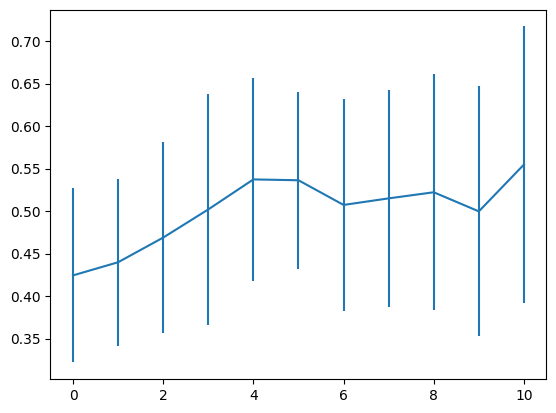

In [74]:
plot_fitnesses(generations)